In [1]:
import logging
import os
import warnings
import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product
import re

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)


c:\Users\noraky\anaconda3\envs\pypsa-earth-03102023\lib\site-packages\pypsa\networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [2]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'

from matplotlib.colors import ListedColormap

In [3]:
path_name = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results_base_no_solar/B_27_'
colors = [teal2,yellow, beige1, green2, beige2, red1, teal4]
years = [2021, 2022, 2023, 2024]#, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035]

In [4]:
# Helper functions

from os import path


def get_power_prod(year,path_name=path_name):
    path = path_name + str(year) + '.nc'
    network = pypsa.Network(path)
    carrier_list = network.generators.carrier.unique()

    production_data = {}

    for carrier in carrier_list:
        total_production = network.generators_t.p.filter(like=carrier, axis=1).sum().sum() / 1000000  # Convert to TWh
        production_data[carrier] = total_production

    hydro_production = 0
    if 'hydro' in network.storage_units.carrier.unique():
        hydro_production += network.storage_units_t.p_dispatch.filter(like='hydro', axis=1).sum().sum() / 1000000  # Convert to TWh

    hydro_production += production_data.pop('ror', 0)
    production_data['hydro'] = hydro_production

    df = pd.DataFrame([production_data], index=[year])
    return df

def get_bus(bus_name, bus_info):
    if bus_name == bus_info['Bus']:
        return bus_info['x'], bus_info['y']

def get_demand(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    el_demand =network.loads_t.p_set
    regional_demand = pd.DataFrame(el_demand.sum()/1000000)
    return regional_demand.sum()

def total_production(year):
    prod = pd.DataFrame(get_power_prod(str(year)))
    prod.drop('load', axis=1, inplace=True)
    return prod.sum().sum()

def get_power_mix(year):
    total_prod = total_production(str(year))
    prod = get_power_prod(str(year))
    prod_series = prod.iloc[0].drop('load', errors='ignore')
    fractions = prod_series / total_prod

    df = pd.DataFrame(fractions).transpose()
    df.index = [year]
    return df

def get_max_output(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    return network.generators.groupby(by='carrier')["p_max_pu"].sum()

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

def get_objective(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    return network.objective /1e6

def get_total_cost(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    return (network.statistics.capex() + network.statistics.opex(aggregate_time="sum")).div(1e6)

def get_emissions(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    return emissions.sum().sum() / 1000000

def get_installed_capacity(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)

    capacities = network.generators.groupby(by='carrier')['p_nom'].sum()

    if 'ror' in capacities:
        capacities['hydro'] = capacities.get('hydro', 0) + capacities.pop('ror')

    if 'hydro' in network.storage_units.carrier.unique():
        hydro_capacity = network.storage_units[network.storage_units.carrier == 'hydro']['p_nom'].sum()
        capacities['hydro'] += hydro_capacity

    capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()
    capacities_df.index = [year]

    return capacities_df

def get_snapshot_generation(year, first_date, second_date, carrier, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(year, first_date, second_date, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    return demand

def get_cap_cost(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    capital_cost = network.generators.groupby('carrier').capital_cost.mean().drop('load')
    return capital_cost

In [53]:
print(get_cap_cost(str(2021)).sum())

879045.8479249715


In [54]:
print(get_installed_capacity(str(2021)))
print(get_power_prod(str(2021)))

carrier     CCGT    OCGT  biomass    oil  onwind  solar  hydro
2021     1363.99  948.92    55.58  11.74   26.54  114.9  732.2
        onwind     solar      CCGT   biomass      OCGT           oil  \
2021  0.002151  1.126654  1.483894  0.429207  0.000004  1.188072e-07   

          load     hydro  
2021  0.000226  6.413175  


INFO:pypsa.io:Imported network B_27_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier     CCGT    OCGT  biomass    oil  onwind  solar  hydro
2021     1363.99  948.92    55.58  11.74   26.54  114.9  732.2


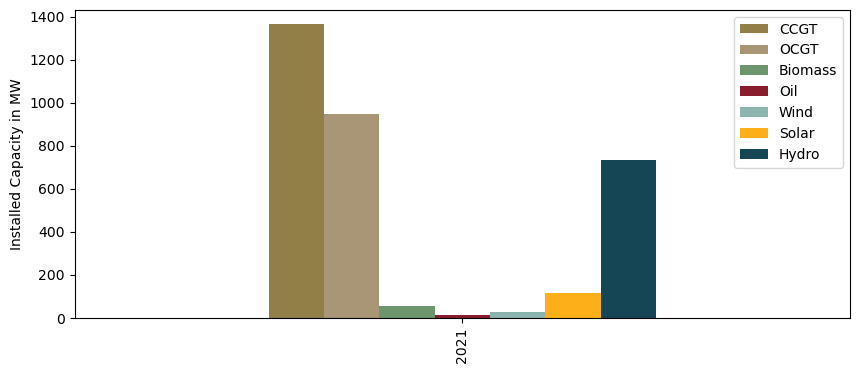

In [5]:
installed_capacity_21 = get_installed_capacity(str(2021))
installed_capacity_21.index = [2021]
print(installed_capacity_21)
colors_cap = [beige1, beige2, green2, red1, teal4, yellow, teal2]
names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro']
installed_capacity_21.columns = names
installed_capacity_21.plot(kind='bar',color=colors_cap,figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.show()

INFO:pypsa.io:Imported network B_27_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


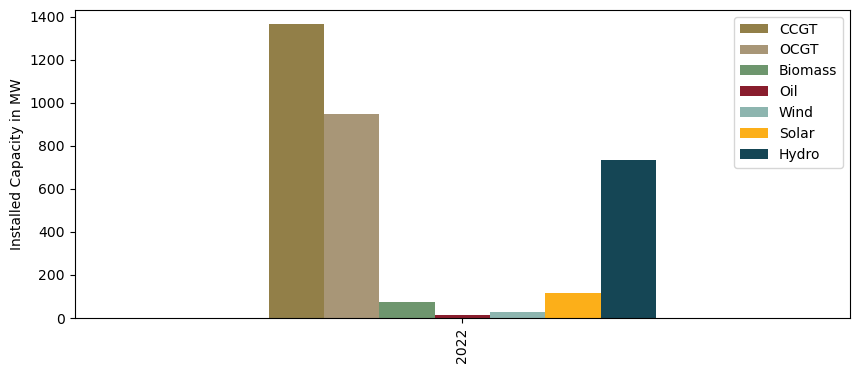

In [6]:
installed_capacity_22 = get_installed_capacity(str(2022))
installed_capacity_22.index = [2022]
colors_cap = [beige1, beige2, green2, red1, teal4, yellow, teal2]
names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro']
installed_capacity_22.columns = names
installed_capacity_22.plot(kind='bar',color=colors_cap,figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.show()

INFO:pypsa.io:Imported network B_27_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_27_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_27_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_27_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


             CCGT        OCGT     biomass        oil     onwind  solar  hydro
2021  1363.990000  948.920000   55.580000  11.740000  26.540000  114.9  732.2
2022  1363.990000  948.920000   71.823008  11.740000  26.540004  114.9  732.2
2023  1363.990004  948.920741  103.627743  11.740011  26.540410  114.9  732.2
2024  1363.990013  948.921340  134.921492  11.740015  26.540661  114.9  732.2


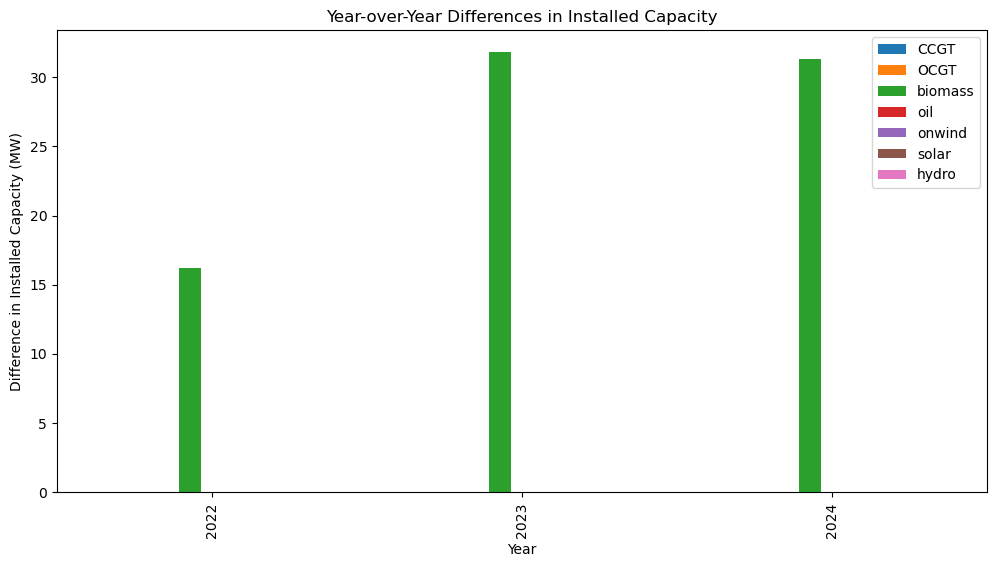

In [7]:
import pandas as pd
carriers = ['CCGT',    'OCGT',  'biomass',    'oil',  'onwind',  'solar',  'hydro']
installed_capacity_all_years = pd.DataFrame(columns=carriers)

# Loop through each year, retrieve the installed capacity, and append it to the DataFrame
for year in years:
    year_capacity_df = get_installed_capacity(str(year))
    installed_capacity_all_years = pd.concat([installed_capacity_all_years, year_capacity_df])

# installed_capacity_all_years now contains the installed capacity for each year
print(installed_capacity_all_years)

# If you want to calculate differences, use .diff() on the DataFrame
# Since the index is set as years, make sure to sort the DataFrame by the index before calculating the difference
installed_capacity_all_years = installed_capacity_all_years.sort_index()
year_over_year_diff = installed_capacity_all_years.diff().dropna()

# Plotting the differences
year_over_year_diff.plot(kind='bar', figsize=(12, 6))
plt.title('Year-over-Year Differences in Installed Capacity')
plt.ylabel('Difference in Installed Capacity (MW)')
plt.xlabel('Year')
plt.show()


In [79]:
data_agg=pd.DataFrame({})
for y in range(2021,2022):
    net=pypsa.Network(path_name + "elec_s_27_ec_lcopt_Co2L-1H.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack()/1000  

grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
grouped_cap_change_B

carrier,CCGT,OCGT,biomass,hydro,onwind,ror,solar
year,,,,,,,
2021,2.302340e-09,9.580657e-08,7.826186e-08,0.0,4.598864e-07,0.0,0.50543


In [98]:
data_agg=pd.DataFrame({})
for y in range(2021,2025):
    net=pypsa.Network(path_name + f"{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack()/1000  

grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
grouped_cap_change_B

carrier,CCGT,OCGT,biomass,hydro,onwind,ror,solar
year,,,,,,,
2021,5.547918e-14,1.130900e-13,1.552853e-10,0.0,1.110747e-09,0.0,0.0
2022,1.423265e-10,1.220803e-08,3.180258e-02,0.0,1.180359e-07,0.0,0.0
2023,9.468755e-10,3.243436e-08,8.660922e-03,0.0,5.903423e-08,0.0,0.0
2024,8.202904e-10,1.082157e-08,6.726278e-08,0.0,2.901271e-08,0.0,0.0


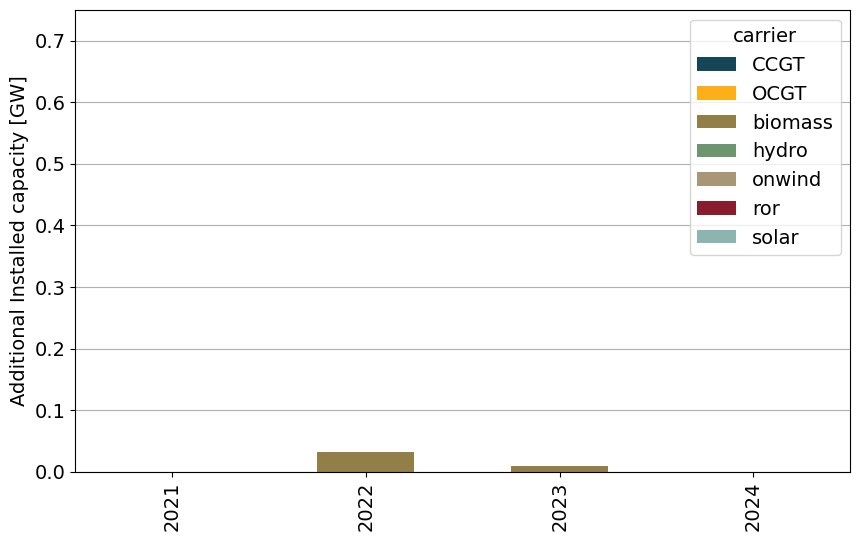

In [99]:
grouped_cap_change_B.plot.bar(stacked=True, figsize=(10, 6),color=colors)

# Add labels and title
plt.ylabel('Additional Installed capacity [GW]')
plt.xlabel('')
plt.xticks(range(len(grouped_cap_change_B.index)), grouped_cap_change_B.index, rotation=90)
plt.ylim(0.0,0.75)
plt.grid(axis = 'y',zorder = 0)

INFO:pypsa.io:Imported network B_27_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_27_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_27_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_27_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


        onwind     solar      CCGT   biomass          OCGT           oil  \
2021  0.002466  0.211168  2.198693  0.628677  4.436159e-09  1.204261e-10   
2022  0.002466  0.211168  2.294106  0.907267  4.287961e-07  9.774898e-09   
2023  0.002467  0.211168  2.387994  1.181382  8.847324e-07  1.808093e-08   
2024  0.002467  0.211168  2.466325  1.410053  8.110850e-07  1.925071e-08   

         hydro  
2021  6.414072  
2022  6.414072  
2023  6.414072  
2024  6.414072  


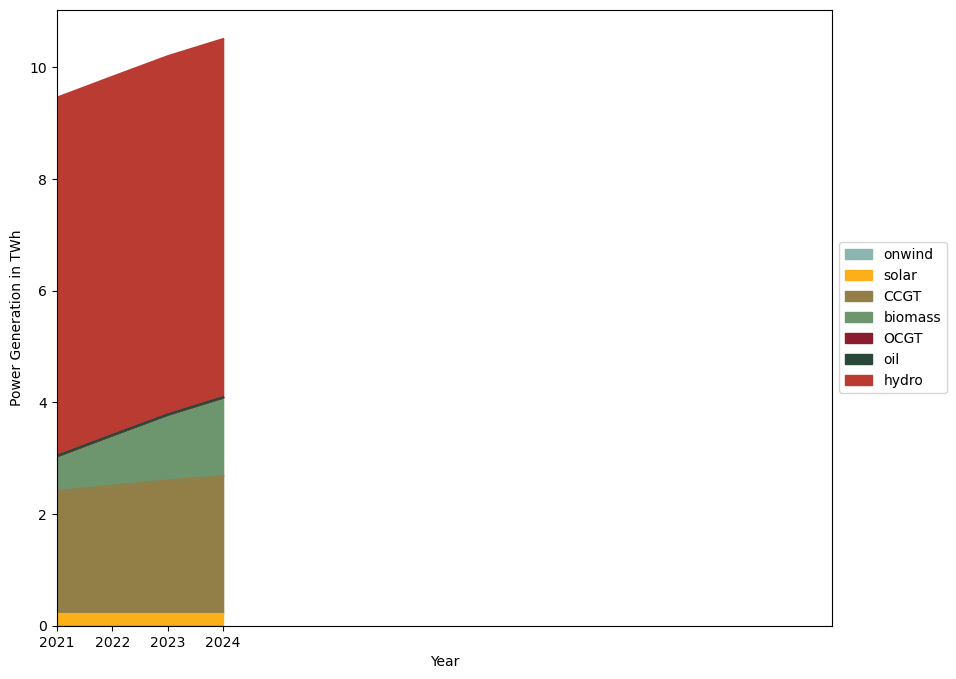

In [8]:
production_sources = [get_power_prod(str(year)) for year in years]
production = pd.concat(production_sources)
if 'load' in production:
  production.drop('load', axis=1, inplace=True)
print(production)
#names = ['Wind', 'Solar', 'CCGT', 'Biomass', 'OCGT', 'Oil', 'Hydro']
#production.columns = names

#colors = [color_for_wind, color_for_solar, color_for_ccgt, color_for_biomass, color_for_ocgt, color_for_oil, color_for_hydro]
colors = [teal4,yellow, beige1, green2, red1, green1, red2, teal2]

production.plot.area(stacked=True, color=colors,figsize=(10, 8))

plt.ylabel('Power Generation in TWh')
plt.xlabel('Year')
plt.xlim(0,14)
plt.xticks(range(len(years)), years)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

        onwind     solar      CCGT   biomass          OCGT           oil  \
2021  0.000261  0.022334  0.232541  0.066491  4.691828e-10  1.273666e-11   

         hydro  
2021  0.678373  


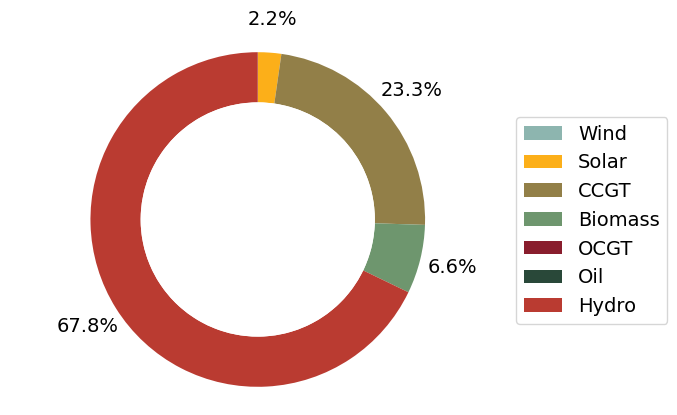

In [109]:
power_mix_df = get_power_mix(2021)
print(power_mix_df)
plt.rcParams['font.size'] = 14

names = ['Wind', 'Solar', 'CCGT', 'Biomass', 'OCGT', 'Oil', 'Hydro']
power_mix_df.columns = names

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(power_mix_df.iloc[0].values, autopct=custom_autopct, colors=colors, startangle=90, counterclock=False, wedgeprops=dict(width=0.3), pctdistance=1.2)

# Hide the zero-value autotexts
for autotext in autotexts:
    if autotext.get_text() == '0.0%':
        autotext.set_visible(False)

ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)


plt.legend(names, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

        onwind     solar      CCGT   biomass      OCGT       oil     hydro
2035  0.000129  0.217095  0.365146  0.026285  0.005649  0.000004  0.385691


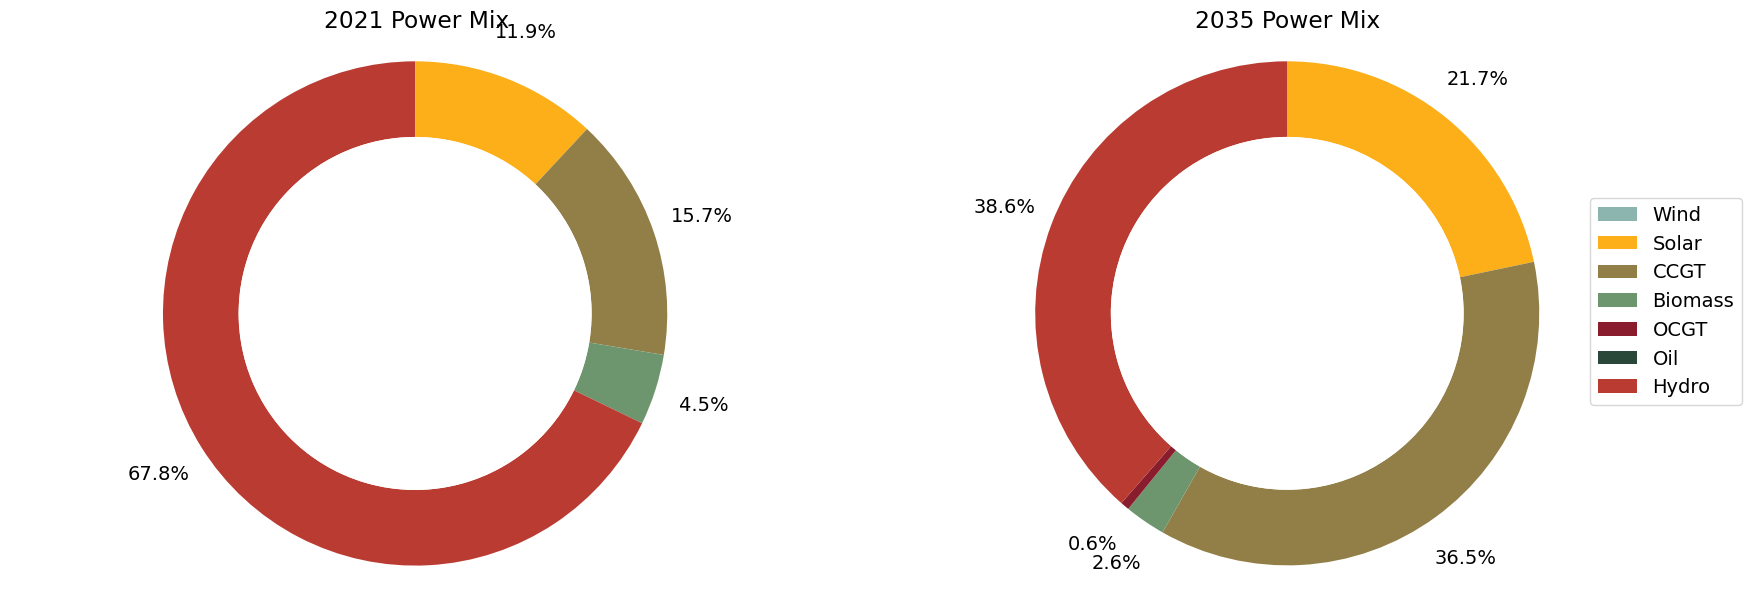

In [62]:
power_mix_21 = get_power_mix(2021)
power_mix_35 = get_power_mix(2035)
print(power_mix_35)

plt.rcParams['font.size'] = 14

names = ['Wind', 'Solar', 'CCGT', 'Biomass', 'OCGT', 'Oil', 'Hydro']
power_mix_21.columns = names
power_mix_35.columns = names

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

wedges1, texts1, autotexts1 = ax1.pie(
    power_mix_21.iloc[0].values, autopct=custom_autopct,
    colors=colors, startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.2
)

wedges2, texts2, autotexts2 = ax2.pie(
    power_mix_35.iloc[0].values, autopct=custom_autopct,
    colors=colors, startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.2
)

for autotext in autotexts1 + autotexts2:
    if autotext.get_text() == '0.0%':
        autotext.set_visible(False)

centre_circle1 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle1)
ax1.set_title('2021 Power Mix')

centre_circle2 = plt.Circle((0,0),0.70,fc='white')
ax2.add_artist(centre_circle2)
ax2.set_title('2035 Power Mix')

ax1.axis('equal')
ax2.axis('equal')

fig.legend(names, loc="center right", bbox_to_anchor=(1, 0.5))

plt.tight_layout(pad=3.0)
plt.show()

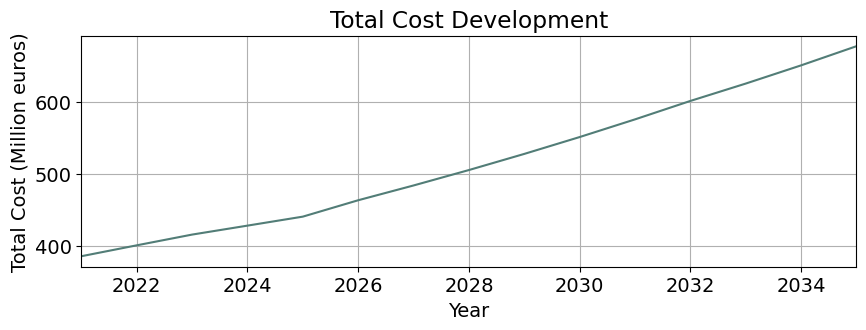

In [121]:
total_costs = [get_total_cost(str(year)).sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_costs, color=teal3)
plt.title('Total Cost Development')
plt.xlabel('Year')
plt.ylabel('Total Cost (Million euros)')
plt.xlim(2021,2035)
plt.grid(zorder = 0)
plt.show()

INFO:pypsa.io:Imported network B_27_2021.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_27_2022.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_27_2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network B_27_2024.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


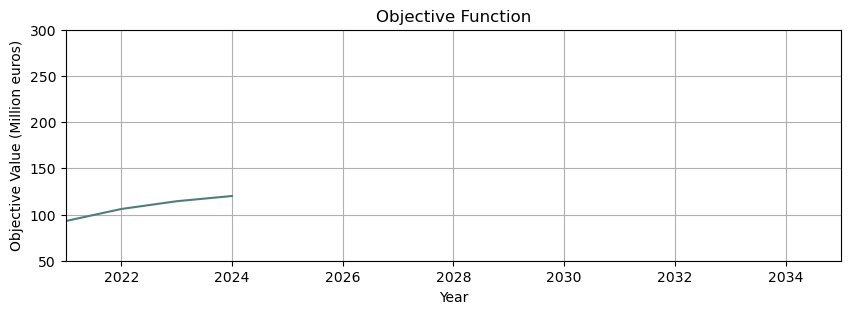

In [13]:
total_objective = [get_objective(str(year)).sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_objective, color=teal3)
plt.title('Objective Function')
plt.xlabel('Year')
plt.ylabel('Objective Value (Million euros)')
plt.xlim(2021,2035)
plt.ylim(50,300)
plt.grid(zorder = 0)
plt.show()

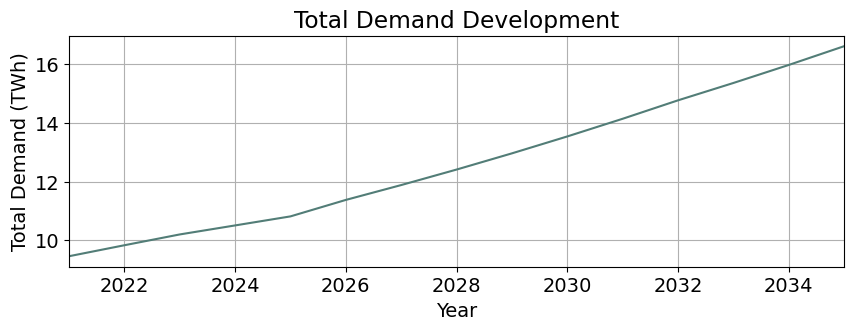

In [64]:
total_demand = [get_demand(str(year)) for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_demand, color=teal3)
plt.title('Total Demand Development')
plt.xlabel('Year')
plt.ylabel('Total Demand (TWh)')
plt.xlim(2021,2035)
plt.grid(zorder = 0)
plt.show()

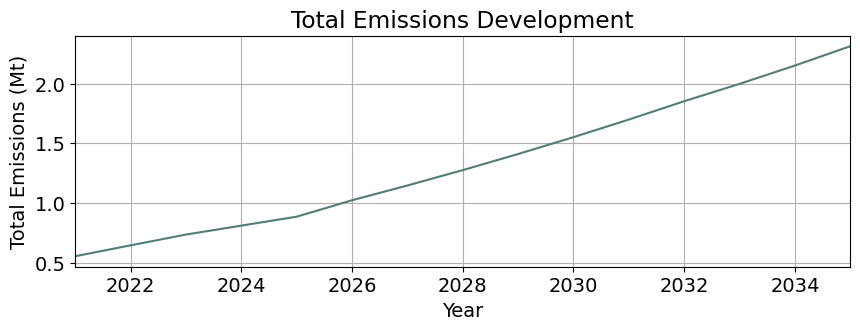

In [65]:
total_emissions = [get_emissions(str(year)) for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_emissions, color=teal3)
plt.title('Total Emissions Development')
plt.xlabel('Year')
plt.ylabel('Total Emissions (Mt)')
plt.xlim(2021,2035)
plt.grid(zorder = 0)
plt.show()

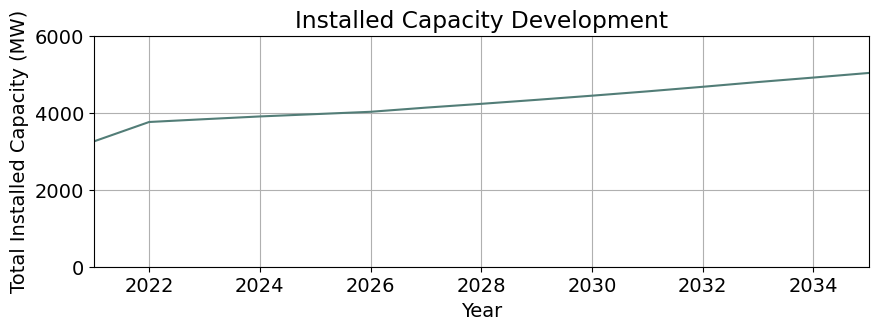

In [66]:
total_capacity = [get_installed_capacity(str(year)).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_capacity, color=teal3)
plt.title('Installed Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(2021,2035)
plt.ylim(0,6000)
plt.grid(zorder = 0)
plt.show()

Oil:  2.3198099050981877e-06
Biomass:  12066.265374002354


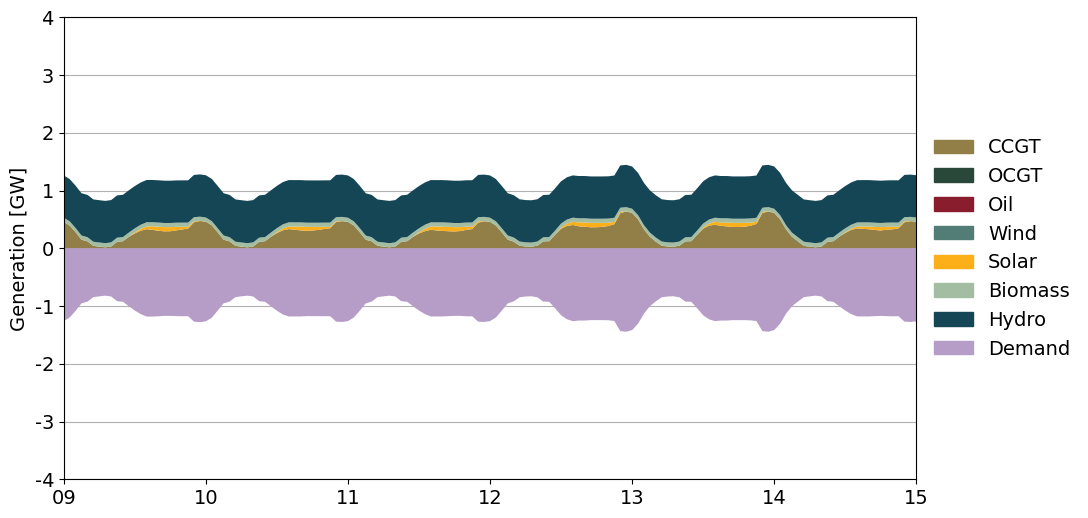

In [110]:
first_date = "2013-01-09"
second_date = "2013-01-15"
year = '2021'

CCGT = get_snapshot_generation(year, first_date, second_date, 'CCGT')
OCGT = get_snapshot_generation(year, first_date, second_date, 'OCGT')
Oil = get_snapshot_generation(year, first_date, second_date, 'oil')
Wind = get_snapshot_generation(year, first_date, second_date, 'onwind')
Solar = get_snapshot_generation(year, first_date, second_date, 'solar')
Biomass = get_snapshot_generation(year, first_date, second_date, 'biomass')
Hydro = get_snapshot_generation(year, first_date, second_date, 'ror')
Hydro += get_snapshot_generation(year, first_date, second_date, 'hydro')
demand = get_snapshot_demand(year, first_date, second_date)   

print('Oil: ', Oil.sum())
print('Biomass: ', Biomass.sum())

fig, ax=plt.subplots(figsize = (11,6))
A = plt.stackplot(CCGT.index,CCGT,OCGT,Oil, Wind, Solar, Biomass, Hydro, #,pbattery
                  colors=[beige1,green1,red1,teal3,yellow,green3,teal2], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand, colors=[purple3], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Generation [GW]')

start_date = pd.to_datetime(first_date)
end_date = pd.to_datetime(second_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-4000, 4000)

CCGT_patch = mpatches.Patch(color=beige1, label ='CCGT')
OCGT_patch = mpatches.Patch(color=green1, label ='OCGT')
oil_patch = mpatches.Patch(color = red1, label = 'Oil')
wind_patch = mpatches.Patch(color=teal3, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
biomass_patch = mpatches.Patch(color = green3, label = 'Biomass')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
load_patch = mpatches.Patch(color=purple3, label ='Demand')
handles=[CCGT_patch,OCGT_patch,oil_patch, wind_patch, solar_patch, biomass_patch, hydro_patch, load_patch]
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)

In [111]:
carrier_list_stat = ['Biomass', 'Combined-Cycle Gas', 'Oil', 'Onshore Wind', 'Open-Cycle Gas', 'Solar']
carrier_list = ['biomass', 'CCGT', 'ror', 'onwind', 'OCGT', 'solar']

n = pypsa.Network(path_name + "2024.nc")
capital_cost = n.generators.groupby('carrier').capital_cost.mean().drop('load')

data_agg=pd.DataFrame({})
for y in range(2021,2025):
    net=pypsa.Network(path_name + f"{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack()  

grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
grouped_cap_change_B


i =0.04
data_add_cost = {}

# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values = []
    # Iterate over the years
    for y in np.arange(2021, 2025):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2025-y):
            if rest > 0:
                value += (grouped_cap_change_B[carrier].loc[y] * capital_cost[carrier])/((1+i)**rest)
            
        carrier_values.append(value)
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[carrier] = carrier_values

# Create the DataFrame from the data dictionary
add_cost_B = pd.DataFrame(data_add_cost, index=np.arange(2021, 2025))
add_cost_B

,biomass,CCGT,ror,onwind,OCGT,solar
2021,1.198054e-01,0.000013,0.0,0.336895,0.000015,0.0
2022,1.667610e+07,0.022675,0.0,24.332133,1.087599,0.0
2023,2.315259e+06,0.076906,0.0,6.204019,1.473099,0.0
2024,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0


In [112]:
objective_value_list_B = []
for y in range(2021,2025):
    net=pypsa.Network(path_name + f"{y}.nc")
    objective_value_list_B.append(net.objective)

In [113]:
print(objective_value_list_B)
print(add_cost_B.sum(axis=1))

[92984956.29663914, 105982465.07692423, 114378197.76908314, 120053907.23682553]
2021    4.567285e-01
2022    1.667613e+07
2023    2.315267e+06
2024    0.000000e+00
dtype: float64


In [114]:
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2025):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_B[y-2021]/((1+i)**(y-2021))+ add_cost_B.sum(axis = 1)[y]/((1+i)**(y-2021))) #objective_value_B[y]+

total_costs_B=pd.DataFrame(data)
total_costs_B

,year,total_costs
0,2021,9.298496e+07
1,2022,1.179410e+08
2,2023,1.078897e+08
3,2024,1.067275e+08


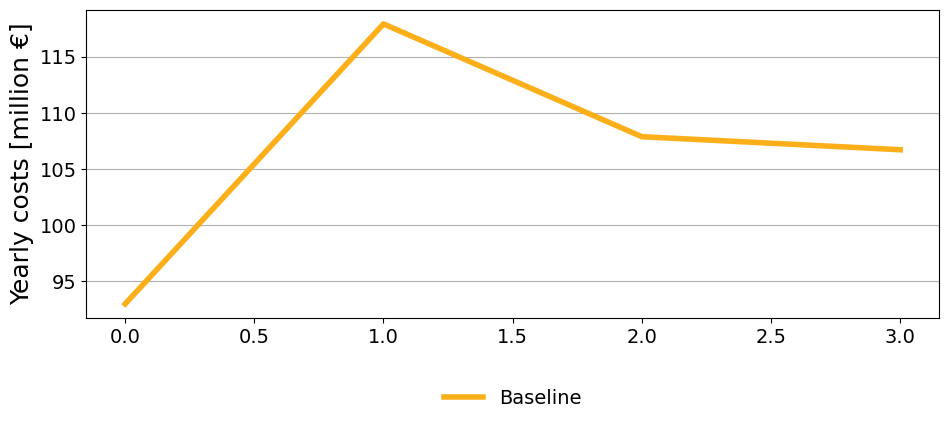

In [115]:
(total_costs_B['total_costs']/1000000).plot(figsize=(11, 4),color = yellow, linewidth = 4, zorder = 2, label = 'Baseline')
plt.ylabel('Yearly costs [million €]',fontsize = 18)
plt.grid(axis='y')
#plt.xlim(2021,2035)
plt.legend(frameon = False, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4)
